In [1]:
!wget -O Tanzania.zip https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp&dl=0
!wget -O IvoryCoast.zip https://www.dropbox.com/scl/fi/lymeixhclxng0gowe9sp7/PlanetIvoryCoast.zip?rlkey=4zuq1y9bed85ruk3lmzkpqwgn&dl=0

--2023-11-16 14:52:15--  https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc381a1cf3fd745205688546087f.dl.dropboxusercontent.com/cd/0/inline/CHq12_2I42cUH1Kef1wT9M4gax-9LMBL7Y58E6ZkW0waE8euA2FFil08rFM2mc89A3XIWQ3NhoEx92Jz6jp3YIeRlY9icfUZB50fqd7Mm-0s10_FwACC5aoNZjopEpPtOH4s8j4T-6aXvFSc4dJ0dzFo/file# [following]
--2023-11-16 14:52:15--  https://uc381a1cf3fd745205688546087f.dl.dropboxusercontent.com/cd/0/inline/CHq12_2I42cUH1Kef1wT9M4gax-9LMBL7Y58E6ZkW0waE8euA2FFil08rFM2mc89A3XIWQ3NhoEx92Jz6jp3YIeRlY9icfUZB50fqd7Mm-0s10_FwACC5aoNZjopEpPtOH4s8j4T-6aXvFSc4dJ0dzFo/file
Resolving uc381a1cf3fd745205688546087f.dl.dropboxusercontent.com (uc381a1cf3fd745205688546087f.dl.dropboxusercontent.com)... 162.125.4.15, 

In [12]:
!pip install rasterio -q
!pip install torchmetrics -q

import rasterio
from rasterio.plot import show
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from skimage import io
import torchvision
import torchvision.transforms as T
from torchvision import tv_tensors
from torchmetrics import F1Score
import sys
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
import pandas as pd
from zipfile import ZipFile

plt.style.use('seaborn-v0_8')

from google.colab import drive
drive.mount('/content/drive')

sys.path.append('drive/MyDrive/Models/Networks/')
from U_Net import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
with ZipFile("Tanzania.zip", 'r') as zipped:
    zipped.extractall(path="./")
with ZipFile("IvoryCoast.zip", 'r') as zipped:
    zipped.extractall(path="./")

os.remove('Tanzania.zip')
os.remove('IvoryCoast.zip')

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [15]:
# These values were calculated using the histograms on notebook 01_02_DataDistributionShift.ipynb
means_CIV = [339.15884,	682.759405,	632.172002,	2872.558996]
oneperc_CIV = [217.0,	528.0,	389.0,	2162.0]
ninenine_CIV = [542.0,	896.0,	984.0,	3877.0]
std_CIV = [67.369635,	79.766812,	131.564375,	365.127796]

means_TNZ = [380.594068,	653.957063,	626.823554,	3069.664905]
oneperc_TNZ = [171.00,	442.0,	302.71,	2236.00]
ninenine_TNZ = [496.29,	805.0,	846.00,	3775.29]
std_TNZ = [63.56492,	72.122137,	103.400951,	295.013028]

class Img_Dataset(Dataset):
    def __init__(self, img_folder, transform = None, split = 'Train', norm = 'StandardScaler', VI = True):
        self.img_folder = img_folder
        self.transform = transform
        self.split = split
        self.norm = norm
        self.VI = VI

    def __len__(self):
        return sum([self.split in i for i in os.listdir(self.img_folder)])//2

    def plot_imgs(self, idx, VIs = False):

        im, g = self.__getitem__(idx)

        if VIs:
            fig, ax = plt.subplots(2,2,figsize = (12,12))

            ax[0,0].imshow(im[[2,1,0],:,:].permute(1,2,0))
            ax[0,0].set_title('Planet image')
            ax[0,1].imshow(g[0,:,:])
            ax[0,1].set_title('Cashew crops GT')

            VIs = im[4:6]

            g1=ax[1,0].imshow(VIs[0], cmap = plt.cm.get_cmap('RdYlGn', 5), vmin = 0, vmax = 1)
            ax[1,0].set_title('NDVI')
            fig.colorbar(g1)
            g2=ax[1,1].imshow(VIs[1], cmap = plt.cm.get_cmap('Blues_r', 5), vmin = 0, vmax = 1)
            ax[1,1].set_title('NDWI')
            fig.colorbar(g2)

        else:
            fig, ax = plt.subplots(1,2,figsize = (12,6))

            ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
            ax[0].set_title('Planet image')
            ax[1].imshow(g[0,:,:])
            ax[1].set_title('Cashew crops GT')


    def __getitem__(self, idx):
        #__getitem__ asks for the sample number idx.

        conversion = T.ToTensor()

        img = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

        if self.VI:
            # Should I normalize this values between 0 and 1?
            if self.norm == 'Linear_1_99':
                ndvi = ((img[:,:,3] - img[:,:,2])/(img[:,:,3] + img[:,:,2]) - 0.37)/(0.86 - (0.37))
                ndwi = ((img[:,:,1] - img[:,:,3])/(img[:,:,3] + img[:,:,1]) - (-0.79))/((-0.41) - (-0.79))
            else:
                ndvi = (img[:,:,3] - img[:,:,2])/(img[:,:,3] + img[:,:,2])
                ndwi = (img[:,:,1] - img[:,:,3])/(img[:,:,3] + img[:,:,1])

        if self.norm == 'StandardScaler':
            for i in range(img.shape[-1]):
                if 'Tanz' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - means_TNZ[i])/(std_TNZ[i])
                elif 'Ivor' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - means_CIV[i])/(std_CIV[i])

        elif self.norm == 'Linear_1_99':
            for i in range(img.shape[-1]):
                if 'Tanz' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - oneperc_TNZ[i])/(ninenine_TNZ[i] - oneperc_TNZ[i])
                elif 'Ivor' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - oneperc_CIV[i])/(ninenine_CIV[i] - oneperc_CIV[i])

        if self.VI:
            ndvi = np.expand_dims(ndvi, axis = 2)
            ndwi = np.expand_dims(ndwi, axis = 2)
            img = np.concatenate((img, ndvi, ndwi), axis = 2)

        img = conversion(img).float()

        img = torchvision.tv_tensors.Image(img)

        GT = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)

        GT = torch.flip(conversion(GT), dims = (1,))

        GT = torchvision.tv_tensors.Image(GT)

        if self.transform != None:
            GT, img = self.transform(GT, img)

        return img, GT

<ipython-input-15-4fd47a22c5c5>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  g1=ax[1,0].imshow(VIs[0], cmap = plt.cm.get_cmap('RdYlGn', 5), vmin = 0, vmax = 1)
<ipython-input-15-4fd47a22c5c5>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  g2=ax[1,1].imshow(VIs[1], cmap = plt.cm.get_cmap('Blues_r', 5), vmin = 0, vmax = 1)


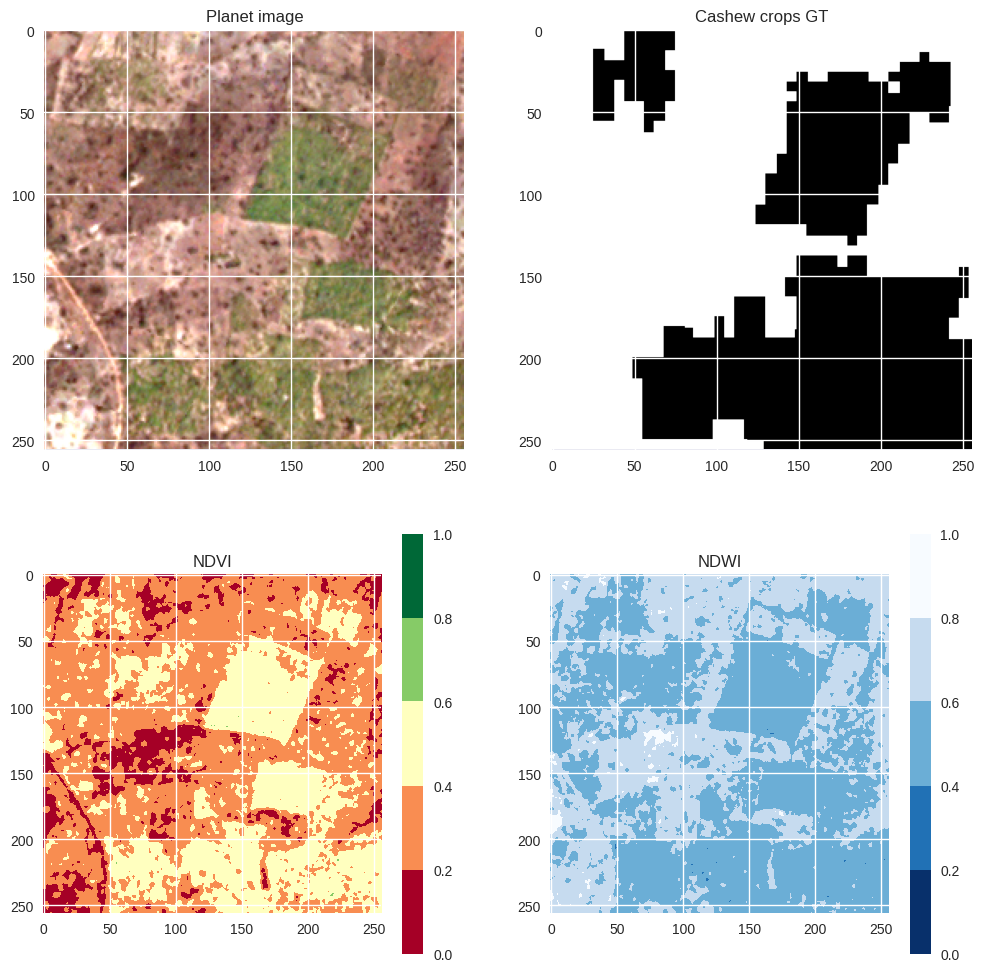

In [17]:
idx = 123
CIV = Img_Dataset('IvoryCoast', norm = 'Linear_1_99')
CIV.plot_imgs(idx, True)

## Visual assessment of distance between features extracted

In [18]:
Use_VI = False
normalization = 'Linear_1_99'

In [19]:
!wget -O Model.pt https://www.dropbox.com/scl/fi/qloxd9wf5ht9gx22g0rtr/BestModel.pt?rlkey=ofl12tsdm71jyeweq79m6sqsh&dl=0 #Change link to assess different model

--2023-11-16 15:06:01--  https://www.dropbox.com/scl/fi/qloxd9wf5ht9gx22g0rtr/BestModel.pt?rlkey=ofl12tsdm71jyeweq79m6sqsh
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc174aa98209e2d261889c502084.dl.dropboxusercontent.com/cd/0/inline/CHrdynQhM8fUgrgYi3FDu8OwY5WF4_PNeLyOkpJI30SKtK8wYMCcOOIIEUmjkvB5EULze6RK17K-bOC5mPpm8NmFrahyPrDcDF2g_Y_NERTxXwqxR0pwPAYeGMTkgX_0EPCj1NewjglQv5ig5ve0g-pg/file# [following]
--2023-11-16 15:06:02--  https://uc174aa98209e2d261889c502084.dl.dropboxusercontent.com/cd/0/inline/CHrdynQhM8fUgrgYi3FDu8OwY5WF4_PNeLyOkpJI30SKtK8wYMCcOOIIEUmjkvB5EULze6RK17K-bOC5mPpm8NmFrahyPrDcDF2g_Y_NERTxXwqxR0pwPAYeGMTkgX_0EPCj1NewjglQv5ig5ve0g-pg/file
Resolving uc174aa98209e2d261889c502084.dl.dropboxusercontent.com (uc174aa98209e2d261889c502084.dl.dropboxusercontent.com)... 162.125.6.15, 2620:1

In [20]:
batch_size = 4

model = torch.load('Model.pt')
model.eval()

CIV_FE = []
TNZ_FE = []

CIV_te = Img_Dataset('IvoryCoast', split = 'Validation', VI = Use_VI, norm = normalization)
TNZ_te = Img_Dataset('Tanzania', split = 'Validation', VI = Use_VI, norm = normalization)

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)

for i, (imgs, GTs) in CIV_iterable_test_loader:

    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        CIV_FE.append(features[j].flatten().cpu().detach().numpy())

for i, (imgs, GTs) in TNZ_iterable_test_loader:

    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        TNZ_FE.append(features[j].flatten().cpu().detach().numpy())

CIV_te = Img_Dataset('IvoryCoast', split = 'Test', VI = Use_VI, norm = normalization)
TNZ_te = Img_Dataset('Tanzania', split = 'Test', VI = Use_VI, norm = normalization)

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)

for i, (imgs, GTs) in CIV_iterable_test_loader:

    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        CIV_FE.append(features[j].flatten().cpu().detach().numpy())

for i, (imgs, GTs) in TNZ_iterable_test_loader:

    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        TNZ_FE.append(features[j].flatten().cpu().detach().numpy())

RuntimeError: ignored

In [ ]:
df_ = pd.DataFrame(TNZ_FE)
df_['domain'] = 'target'
df = pd.DataFrame(CIV_FE)
df['domain'] = 'source'
# df = df.sample(len(df_), random_state = 8) #  To get same amount of images per domain

In [ ]:
df = pd.concat([df, df_])
X = df.iloc[:,:-1]

In [ ]:
comps = 2

tsne = TSNE(comps, perplexity = 50, n_iter =  1500, random_state=8)

FE_tsne = tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (9.5,5))

sns.scatterplot(x = FE_tsne[:,0], y = FE_tsne[:,1], hue = df['domain'], ax = ax, palette = ['darkblue', 'darkred'])

ax.set_title('t-SNE of features extracted for test and validation datasets\nof each domain using Source-Only 4 Up-Layer model')

fig.savefig('../imgs/t_SNE_SourceOnly.png')

## Mean euclidean distance

In [ ]:
mean_domains = df.groupby('domain').mean().T

euc_dist = np.sqrt(np.sum((mean_domains['source'] - mean_domains['target'])**2))

In [ ]:
euc_dist

251.67137

In [ ]:
for i in range(len(df[df['domain'] == 'target'])):
    np.sqrt(np.sum((df[df['domain'] == 'source'] - df[df['domain'] == 'target'].iloc[0])**2, axis = 1))

In [ ]:
distances = [72, 182, 118, 127]

In [ ]:
model

NameError: name 'Model' is not defined